In [1]:
#@title Runtime
use_tpu = False #@param

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import urllib
from dataclasses import dataclass
import tensorflowjs as tfjs
# import tensorflow_decision_forests as tfdf
import json
from tqdm import tqdm
import seaborn as sns
np.random.seed(0)

In [3]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/human-positive.npz",
    "positive.npz",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/human-negative.npz",
    "negative.npz",
)
with np.load("positive.npz") as r:
    pos_data = r[list(r.keys())[0]]
with np.load("negative.npz") as r:
    neg_data = r['seqs']
    weights = r['weights']

# create labels and stich it all into one
# tensor
# labels = np.concatenate(
#     (
#         np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
#         np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
#     ),
#     axis=0,
# )
# weights = np.concatenate(
#     (np.ones((pos_data.shape[0]), dtype=pos_data.dtype), 
#      weights)
# )
# features = np.concatenate((pos_data, neg_data), axis=0)
# pos_data_lengths = np.count_nonzero(pos_data, axis=1)
# neg_data_lengths = np.count_nonzero(neg_data, axis=1)

In [6]:
def encoder(seq, max_length=200):
    alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
    vec = np.zeros(max_length)
    for i,l in enumerate(seq):
        vec[i] = alphabet.index(l) + 1
    return vec
# sample unlabeled data
def sample_permutations_from_vec(data_lengths, labeled_unlabeled_ratio=0.2, max_sequence_length=200):
    alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
    with open("../pdb_dist.txt", 'r') as f:
        # the probabilities in this file are sorted based on the alphabet list above
        pdb_dist = f.read().split()
        pdb_dist = [float(item) for item in pdb_dist]
#     unlabeled_seq_lengths = vec_pep_length(positive_data, ohe_vec=False)
#     print(unlabeled_seq_lengths)
    sampled_lengths = []
    for length in data_lengths:
        length_sample_batch = np.ones(int(1/labeled_unlabeled_ratio), dtype=int) * length
        sampled_lengths.append(length_sample_batch)
    sampled_lengths = np.array(sampled_lengths).flatten()
    sampled_sequences = []
    sampled_vecs = []
    for length in tqdm(sampled_lengths):
#         print(length)
    #         random_alphabet_index = np.random.randint(len(alphabet), size=length)
        # sample alphabet index based on weighted amino acid frequencies in pdb
        random_alphabet_index = np.random.choice(len(alphabet), size=length, p=pdb_dist)
        for _ in range(length):
            pep = ''.join([alphabet[m] for m in random_alphabet_index])
        vec_pep = encoder(pep)
        # pad zeros
    #     print(ohe_pep.shape)
#         ohe_pep = np.concatenate([ohe_pep, np.zeros((max_sequence_length-ohe_pep.shape[0],20))],axis=0)
        sampled_vecs.append(vec_pep)
        sampled_sequences.append(pep)
#     sampled_vecs = np.array(sampled_vecs)
    return sampled_sequences, sampled_vecs
# ohe_sequence_list = np.concatenate([ohe_sequence_list, np.zeros((190,10))],axis=1)
pos_data_lengths = np.count_nonzero(pos_data, axis=1) + 1
neg_data_lengths = np.count_nonzero(neg_data, axis=1) + 1
labeled_unlabeled_ratio = 0.2
sampled_sequences, sampled_vecs = sample_permutations_from_vec(pos_data_lengths, labeled_unlabeled_ratio=0.2)
sampled_vecs = np.array(sampled_vecs)
# X_unlabeled = sampled_vecs
unlabeled_data_lengths = []
for seq in sampled_sequences:
    unlabeled_data_lengths.append(len(seq))

100%|██████████| 18000/18000 [00:00<00:00, 24777.36it/s]


In [7]:
X_positive = pos_data
X_negative = neg_data
X_unlabeled = sampled_vecs
print('Positive data:', pos_data.shape[0])
print('Negative data:', neg_data.shape[0])
print('Sampled unlabeled data:', len(sampled_sequences))

Positive data: 3600
Negative data: 13585
Sampled unlabeled data: 18000


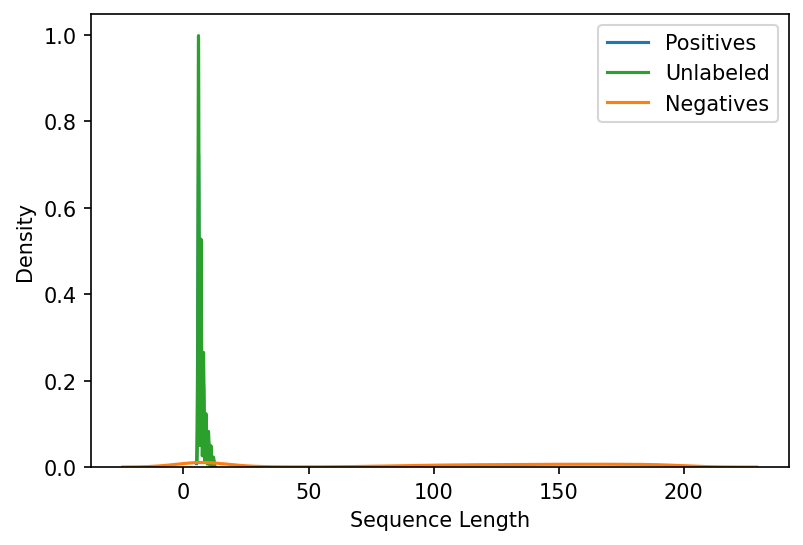

In [12]:
fig, ax = plt.subplots(dpi=150)
sns.kdeplot(pos_data_lengths, ax=ax, label='Positives', color='C0')
ax.set_xlabel('Sequence Length')
# ax.set_title(f'{peptide_label}')
sns.kdeplot(unlabeled_data_lengths, ax=ax, label='Unlabeled', color='C2')
sns.kdeplot(neg_data_lengths, ax=ax, label='Negatives', color='C1')
plt.legend()

In [13]:
def decoder(seq_vector):
  alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
  seq = []
  for i, index in enumerate(seq_vector):
    if index == 0:
      break
    seq.append(alphabet[int(index)-1])
  seq = ''.join(seq)
  return seq
# need to decode postive and negative data to get UniRep representations
pos_sequences = []
for f in pos_data:
  pos_sequences.append(decoder(f))

neg_sequences = []
for f in neg_data:
  neg_sequences.append(decoder(f))

In [14]:
# Generating UniRep representations for postives, negatives and unlableled (This cell takes long to run)
from jax_unirep import get_reps
h_avg, h_final, c_final = get_reps(pos_sequences)
pos_UniRep = h_avg

h_avg, h_final, c_final = get_reps(neg_sequences)
neg_UniRep = h_avg

h_avg, h_final, c_final = get_reps(sampled_sequences)
unlabeled_UniRep = h_avg

/home/mgholiza/.conda/envs/covid-19/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)
/home/mgholiza/.conda/envs/covid-19/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [19]:
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.model_selection import KFold
# from sklearn.metrics import f1_score
# from sklearn.metrics import recall_score
# kf = KFold(n_splits=5, random_state=None, shuffle=True)
# f1_scores = []
# recall_scores = []
# i = 0

# for train_index, test_index in kf.split(pos_UniRep):
#     X_train_positive_lof, X_test_positive_lof = pos_UniRep[train_index], pos_UniRep[test_index]
# #     s_train_positive_svm = np.ones(X_train_positive_svm.shape[0])
# #     s_test_positive_svm = y[train_index], y[test_index]
#     s_test_lof = np.ones(X_test_positive_lof.shape[0])
#     lof = LocalOutlierFactor(n_neighbors=64, algorithm='auto',
#                              metric='cosine', contamination=0.01,
#                              novelty=True, n_jobs=20, leaf_size=40)
#     lof.fit(X_train_positive_lof)
# #     X_validation_svm = np.concatenate([X_positive_test, X_unlabeled_test])

#     # Make prediction
#     s_pred = lof.predict(X_test_positive_lof)
#     f1 = f1_score(s_test_lof, s_pred, average='macro')
#     r = recall_score(s_test_lof, s_pred, average='macro')
#     print(f'Fold {i+1} - recall : {r:.3f}, f1 score : {f1:.3f}')
#     f1_scores.append(f1)
#     recall_scores.append(r)
#     i += 1
# #     break
# # lof_f1_score
# lof_f1_score = np.mean(f1_scores)
# lof_recall_score = np.mean(recall_scores)
# print(f'\nMean 5-Fold\n f1 score = {lof_f1_score:.3f}\n recall = {lof_recall_score:.3f}')

In [25]:
def mahalanobis_distance(x, data):
    data = np.unique(data, axis=0)
    x_minus_mu = x - np.mean(data, axis=0, keepdims=True)
    cov = np.cov(data.T)
    inv_covmat = np.linalg.pinv(cov)
    left_term = x_minus_mu @ inv_covmat
    mahal = left_term @ x_minus_mu.T
    return mahal.diagonal()
unlabeled_mahal_d = mahalanobis_distance(unlabeled_UniRep, pos_UniRep)
sorted_max_mahal_d_index = np.argsort(unlabeled_mahal_d)[::-1]
outlier_index = sorted_max_mahal_d_index[sorted_max_mahal_d_index[:100]]
initial_RNs = X_unlabeled[outlier_index]

In [26]:
# Shuffling data
shuffled_indices = np.random.permutation(len(pos_data))
X_positive = pos_data[shuffled_indices]
shuffled_indices = np.random.permutation(len(neg_data))
X_negative = neg_data[shuffled_indices]
# shuffled_indices = np.random.permutation(len(sampled_vecs))
# X_unlabeled = sampled_vecs[shuffled_indices]

In [27]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(X_positive), 
                batch_size=16, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.1
               )

def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts/tf.reduce_sum(counts)

def build_model(L):
    inputs = tf.keras.Input(shape=(L,))
    input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    x = tf.keras.layers.Concatenate()([x, input_f])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[inputs, input_f], outputs=yhat, name='hemo-rnn')
    return model

In [28]:
from sklearn.model_selection import train_test_split
X_train_positive, X_test_positive, y_train_positive, y_test_positive = train_test_split(X_positive, np.ones(X_positive.shape[0]),
                                                                                        test_size=0.2, random_state=42)

In [31]:
RNs = initial_RNs
down_sampled_X_train = X_train_positive[np.random.choice(X_train_positive.shape[0], size=RNs.shape[0], replace=False)]
X_train_with_RN = np.concatenate([X_train_positive, RNs])
counts_X_train_with_RN= np.array([counts_aa(xi) for xi in X_train_with_RN])
y_train_with_RN = np.concatenate([np.ones(X_train_positive.shape[0]), np.zeros(RNs.shape[0])])
shuffler = np.random.permutation(len(X_train_with_RN))
X_train_with_RN = X_train_with_RN[shuffler]
# counts_X_train_with_RN = counts_X_train_with_RN[shuffler]
y_train_with_RN = y_train_with_RN[shuffler]
X_test = np.concatenate([X_test_positive, X_negative])
y_test = np.concatenate([np.ones(y_test_positive.shape[0]), np.zeros(X_negative.shape[0])])
# removing intial RN seeds from unlabeled
RU = np.delete(X_unlabeled, outlier_index[0],axis=0)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.9,
                                                        patience=5, min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, min_delta=1e-2, restore_best_weights=True)
L = None
for i in tqdm(range(50)):
    tf.keras.backend.clear_session()
    model = build_model(L)
    model.compile(
            optimizer=tf.optimizers.Adam(1e-3, clipnorm=1.0),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)],
            )
    history = model.fit(
        [X_train_with_RN, counts_X_train_with_RN] , y_train_with_RN,
        validation_data=([X_test, np.array([counts_aa(xi) for xi in X_test])] , y_test), 
        epochs=50,
        batch_size=16,
    #     batch_size=64,
    #     steps_per_epoch=100,
        # early_stopping
        callbacks=[reduce_lr, early_stopping],
        verbose=1,
    #         class_weight=class_weights
    )
    prob = model.predict([RU, np.array([counts_aa(xi) for xi in RU])])
    V = RU[np.argsort(prob[:,0])] 
#     break
#     print(f'Negatives found: {V.shape[0]}')
#     if V.shape[0] == 0:
#         print('All unlabeled were predicted as positive')
#         RNs = outlier_values
#         break
    # print(V.shape)
#     else:
        # print(RNs.shape)
#         n_downsample = V.shape[0] - X_train_positive_svm.shape[0]
#         print(RNs.shape) 
    if i == 0:
        RNs = np.empty(shape=(0, 200))

    RNs = np.concatenate([RNs, V[:20*(i+1)]])
#     RNs = V[:80*(i+1)]
#         RU = RU[:][np.squeeze(prob > 0.001)]
    RU = np.delete(RU, np.argsort(prob[:,0])[:20*(i+1)], axis=0)
    print(f'Reliable negative size: {RNs.shape[0]}   Unlabeled size: {RU.shape[0]}')
    if RU.shape[0] == 0:
        print('All unlabeled were predicted as negative')
        break
    if RNs.shape[0] > X_train_positive.shape[0]:
        print('RNs size exceeded positives size')
        break
#         RNs = equalizer(X_train_positive_lof, RNs)
    down_sampled_X_train = X_train_positive[np.random.choice(X_train_positive.shape[0], size=RNs.shape[0], replace=False)]
    print(f'pos size: {down_sampled_X_train.shape[0]} RN size: {RNs.shape[0]}')
    X_train_with_RN = np.concatenate([X_train_positive, RNs])
    counts_X_train_with_RN = np.array([counts_aa(xi) for xi in X_train_with_RN])
    y_train_with_RN = np.concatenate([np.ones(X_train_positive.shape[0]), np.zeros(RNs.shape[0])])
    shuffler = np.random.permutation(len(X_train_with_RN))
    X_train_with_RN = X_train_with_RN[shuffler]
    counts_X_train_with_RN = counts_X_train_with_RN[shuffler]
    y_train_with_RN = y_train_with_RN[shuffler]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
187/187 [==============================] - 24s 81ms/step - loss: 0.1733 - auc: 0.4430 - binary_accuracy: 0.9570 - val_loss: 3.4626 - val_auc: 0.8657 - val_binary_accuracy: 0.0503
Epoch 2/50
187/187 [==============================] - 13s 68ms/step - loss: 0.1204 - auc: 0.7772 - binary_accuracy: 0.9661 - val_loss: 1.6915 - val_auc: 0.8705 - val_binary_accuracy: 0.4263
Epoch 3/50
187/187 [==============================] - 13s 68ms/step - loss: 0.0936 - auc: 0.8885 - binary_accuracy: 0.9718 - val_loss: 2.1667 - val_auc: 0.8303 - val_binary_accuracy: 0.4114
Epoch 4/50
187/187 [==============================] - 13s 68ms/step - loss: 0.0849 - auc: 0.9361 - binary_accuracy: 0.9725 - val_loss: 3.7716 - val_auc: 0.6133 - val_binary_accuracy: 0.0816
Epoch 5/50
187/187 [==============================] - 13s 68ms/step - loss: 0.0775 - auc: 0.9162 - binary_accuracy: 0.9779 - val_loss: 3.1270 - val_auc: 0.8384 - val_binary_accuracy: 0.0663
Epoch 6/50
187/187 [==============================

  2%|▏         | 1/50 [05:29<4:28:53, 329.25s/it]

Epoch 1/50
182/182 [==============================] - 24s 89ms/step - loss: 0.0650 - auc: 0.5734 - binary_accuracy: 0.9821 - val_loss: 5.0860 - val_auc: 0.5545 - val_binary_accuracy: 0.0503
Epoch 2/50
182/182 [==============================] - 13s 70ms/step - loss: 0.0326 - auc: 0.8550 - binary_accuracy: 0.9931 - val_loss: 4.7254 - val_auc: 0.6603 - val_binary_accuracy: 0.0949
Epoch 3/50
182/182 [==============================] - 13s 69ms/step - loss: 0.0152 - auc: 0.9679 - binary_accuracy: 0.9959 - val_loss: 4.5332 - val_auc: 0.7563 - val_binary_accuracy: 0.0714
Epoch 4/50
182/182 [==============================] - 13s 69ms/step - loss: 0.0110 - auc: 0.9973 - binary_accuracy: 0.9966 - val_loss: 3.6718 - val_auc: 0.8441 - val_binary_accuracy: 0.1330
Epoch 5/50
182/182 [==============================] - 13s 70ms/step - loss: 0.0134 - auc: 0.9452 - binary_accuracy: 0.9959 - val_loss: 5.0841 - val_auc: 0.6780 - val_binary_accuracy: 0.0780
Epoch 6/50
182/182 [==============================

  4%|▍         | 2/50 [08:23<3:46:19, 282.90s/it]

Epoch 1/50
184/184 [==============================] - 25s 83ms/step - loss: 0.0803 - auc: 0.8941 - binary_accuracy: 0.9765 - val_loss: 4.6259 - val_auc: 0.5806 - val_binary_accuracy: 0.0512
Epoch 2/50
184/184 [==============================] - 13s 69ms/step - loss: 0.0217 - auc: 0.9948 - binary_accuracy: 0.9949 - val_loss: 5.0788 - val_auc: 0.5932 - val_binary_accuracy: 0.0542
Epoch 3/50
184/184 [==============================] - 13s 68ms/step - loss: 0.0157 - auc: 0.9971 - binary_accuracy: 0.9949 - val_loss: 5.3740 - val_auc: 0.5867 - val_binary_accuracy: 0.0817
Epoch 4/50
184/184 [==============================] - 12s 68ms/step - loss: 0.0110 - auc: 0.9992 - binary_accuracy: 0.9969 - val_loss: 5.9855 - val_auc: 0.5424 - val_binary_accuracy: 0.0668
Epoch 5/50
184/184 [==============================] - 13s 69ms/step - loss: 0.0177 - auc: 0.9806 - binary_accuracy: 0.9966 - val_loss: 6.1331 - val_auc: 0.5020 - val_binary_accuracy: 0.0517
Epoch 6/50
184/184 [==============================

  6%|▌         | 3/50 [12:10<3:28:15, 265.86s/it]

Epoch 1/50
188/188 [==============================] - 25s 82ms/step - loss: 0.0653 - auc: 0.9768 - binary_accuracy: 0.9797 - val_loss: 4.8987 - val_auc: 0.5016 - val_binary_accuracy: 0.0528
Epoch 2/50
188/188 [==============================] - 13s 68ms/step - loss: 0.0202 - auc: 0.9881 - binary_accuracy: 0.9957 - val_loss: 3.4932 - val_auc: 0.8572 - val_binary_accuracy: 0.0772
Epoch 3/50
188/188 [==============================] - 13s 68ms/step - loss: 0.0160 - auc: 0.9946 - binary_accuracy: 0.9957 - val_loss: 4.1592 - val_auc: 0.7406 - val_binary_accuracy: 0.1734
Epoch 4/50
188/188 [==============================] - 13s 68ms/step - loss: 0.0148 - auc: 0.9949 - binary_accuracy: 0.9957 - val_loss: 4.4377 - val_auc: 0.7320 - val_binary_accuracy: 0.1452
Epoch 5/50
188/188 [==============================] - 12s 66ms/step - loss: 0.0098 - auc: 0.9996 - binary_accuracy: 0.9973 - val_loss: 4.2064 - val_auc: 0.7407 - val_binary_accuracy: 0.2422
Epoch 6/50
188/188 [==============================

  8%|▊         | 4/50 [15:07<3:03:23, 239.21s/it]

Epoch 1/50
193/193 [==============================] - 24s 83ms/step - loss: 0.0831 - auc: 0.9701 - binary_accuracy: 0.9705 - val_loss: 5.3045 - val_auc: 0.4991 - val_binary_accuracy: 0.0564
Epoch 2/50
193/193 [==============================] - 13s 66ms/step - loss: 0.0189 - auc: 0.9978 - binary_accuracy: 0.9948 - val_loss: 5.0937 - val_auc: 0.7089 - val_binary_accuracy: 0.0509
Epoch 3/50
193/193 [==============================] - 13s 66ms/step - loss: 0.0141 - auc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 2.4003 - val_auc: 0.8846 - val_binary_accuracy: 0.0768
Epoch 4/50
193/193 [==============================] - 13s 66ms/step - loss: 0.0145 - auc: 0.9996 - binary_accuracy: 0.9958 - val_loss: 4.3965 - val_auc: 0.7264 - val_binary_accuracy: 0.1382
Epoch 5/50
193/193 [==============================] - 13s 66ms/step - loss: 0.0116 - auc: 0.9996 - binary_accuracy: 0.9964 - val_loss: 2.8416 - val_auc: 0.8675 - val_binary_accuracy: 0.1372
Epoch 6/50
193/193 [==============================

 10%|█         | 5/50 [18:03<2:45:21, 220.48s/it]

Epoch 1/50
199/199 [==============================] - 25s 77ms/step - loss: 0.0591 - auc: 0.9892 - binary_accuracy: 0.9799 - val_loss: 5.2614 - val_auc: 0.6011 - val_binary_accuracy: 0.0928
Epoch 2/50
199/199 [==============================] - 13s 65ms/step - loss: 0.0198 - auc: 0.9976 - binary_accuracy: 0.9943 - val_loss: 2.4270 - val_auc: 0.8740 - val_binary_accuracy: 0.3467
Epoch 3/50
199/199 [==============================] - 13s 65ms/step - loss: 0.0155 - auc: 0.9993 - binary_accuracy: 0.9953 - val_loss: 3.5801 - val_auc: 0.7710 - val_binary_accuracy: 0.3284
Epoch 4/50
199/199 [==============================] - 13s 65ms/step - loss: 0.0129 - auc: 0.9963 - binary_accuracy: 0.9972 - val_loss: 4.1069 - val_auc: 0.7712 - val_binary_accuracy: 0.1860
Epoch 5/50
199/199 [==============================] - 13s 65ms/step - loss: 0.0089 - auc: 0.9999 - binary_accuracy: 0.9972 - val_loss: 2.5933 - val_auc: 0.8369 - val_binary_accuracy: 0.4805
Epoch 6/50
199/199 [==============================

 12%|█▏        | 6/50 [24:01<3:11:46, 261.50s/it]

Epoch 1/50
207/207 [==============================] - 25s 75ms/step - loss: 0.0893 - auc: 0.9911 - binary_accuracy: 0.9676 - val_loss: 3.6600 - val_auc: 0.6162 - val_binary_accuracy: 0.2760
Epoch 2/50
207/207 [==============================] - 13s 63ms/step - loss: 0.0215 - auc: 0.9994 - binary_accuracy: 0.9942 - val_loss: 1.8715 - val_auc: 0.8740 - val_binary_accuracy: 0.5813
Epoch 3/50
207/207 [==============================] - 13s 63ms/step - loss: 0.0124 - auc: 0.9984 - binary_accuracy: 0.9973 - val_loss: 2.8712 - val_auc: 0.8000 - val_binary_accuracy: 0.4888
Epoch 4/50
207/207 [==============================] - 13s 62ms/step - loss: 0.0140 - auc: 0.9973 - binary_accuracy: 0.9964 - val_loss: 1.9559 - val_auc: 0.8580 - val_binary_accuracy: 0.6542
Epoch 5/50
207/207 [==============================] - 13s 62ms/step - loss: 0.0096 - auc: 0.9998 - binary_accuracy: 0.9976 - val_loss: 1.6444 - val_auc: 0.8774 - val_binary_accuracy: 0.7553
Epoch 6/50
207/207 [==============================

 14%|█▍        | 7/50 [27:01<2:49:57, 237.16s/it]

Epoch 1/50
215/215 [==============================] - 22s 71ms/step - loss: 0.0728 - auc: 0.9932 - binary_accuracy: 0.9765 - val_loss: 4.9833 - val_auc: 0.5122 - val_binary_accuracy: 0.0573
Epoch 2/50
215/215 [==============================] - 12s 58ms/step - loss: 0.0175 - auc: 0.9981 - binary_accuracy: 0.9968 - val_loss: 4.2333 - val_auc: 0.7238 - val_binary_accuracy: 0.1501
Epoch 3/50
215/215 [==============================] - 13s 59ms/step - loss: 0.0128 - auc: 0.9994 - binary_accuracy: 0.9971 - val_loss: 4.2013 - val_auc: 0.6682 - val_binary_accuracy: 0.2816
Epoch 4/50
215/215 [==============================] - 12s 58ms/step - loss: 0.0149 - auc: 0.9987 - binary_accuracy: 0.9971 - val_loss: 3.9860 - val_auc: 0.7141 - val_binary_accuracy: 0.3376
Epoch 5/50
215/215 [==============================] - 13s 59ms/step - loss: 0.0133 - auc: 0.9978 - binary_accuracy: 0.9974 - val_loss: 3.6202 - val_auc: 0.7853 - val_binary_accuracy: 0.3027
Epoch 6/50
215/215 [==============================

 16%|█▌        | 8/50 [29:55<2:32:49, 218.33s/it]

Epoch 1/50
225/225 [==============================] - 22s 68ms/step - loss: 0.0899 - auc: 0.9906 - binary_accuracy: 0.9697 - val_loss: 4.4640 - val_auc: 0.5826 - val_binary_accuracy: 0.1600
Epoch 2/50
225/225 [==============================] - 13s 56ms/step - loss: 0.0195 - auc: 0.9981 - binary_accuracy: 0.9961 - val_loss: 5.3511 - val_auc: 0.5238 - val_binary_accuracy: 0.0805
Epoch 3/50
225/225 [==============================] - 13s 56ms/step - loss: 0.0134 - auc: 0.9990 - binary_accuracy: 0.9969 - val_loss: 5.8445 - val_auc: 0.5185 - val_binary_accuracy: 0.0671
Epoch 4/50
225/225 [==============================] - 13s 56ms/step - loss: 0.0131 - auc: 0.9992 - binary_accuracy: 0.9964 - val_loss: 5.0700 - val_auc: 0.6060 - val_binary_accuracy: 0.1318
Epoch 5/50
225/225 [==============================] - 13s 56ms/step - loss: 0.0194 - auc: 0.9983 - binary_accuracy: 0.9936 - val_loss: 5.9639 - val_auc: 0.5197 - val_binary_accuracy: 0.0574
Epoch 6/50
225/225 [==============================

 18%|█▊        | 9/50 [33:01<2:22:31, 208.58s/it]

Epoch 1/50
237/237 [==============================] - 25s 66ms/step - loss: 0.0536 - auc: 0.9971 - binary_accuracy: 0.9844 - val_loss: 1.3956 - val_auc: 0.8795 - val_binary_accuracy: 0.7511
Epoch 2/50
237/237 [==============================] - 13s 55ms/step - loss: 0.0177 - auc: 0.9998 - binary_accuracy: 0.9952 - val_loss: 1.7481 - val_auc: 0.8747 - val_binary_accuracy: 0.6778
Epoch 3/50
237/237 [==============================] - 13s 56ms/step - loss: 0.0161 - auc: 0.9996 - binary_accuracy: 0.9958 - val_loss: 4.7505 - val_auc: 0.6926 - val_binary_accuracy: 0.1485
Epoch 4/50
237/237 [==============================] - 13s 56ms/step - loss: 0.0072 - auc: 0.9992 - binary_accuracy: 0.9989 - val_loss: 2.7881 - val_auc: 0.8200 - val_binary_accuracy: 0.4707
Epoch 5/50
237/237 [==============================] - 13s 55ms/step - loss: 0.0122 - auc: 0.9996 - binary_accuracy: 0.9979 - val_loss: 3.8436 - val_auc: 0.8072 - val_binary_accuracy: 0.2508
Epoch 6/50
237/237 [==============================

 20%|██        | 10/50 [37:36<2:32:20, 228.52s/it]

Epoch 1/50
249/249 [==============================] - 24s 66ms/step - loss: 0.0757 - auc: 0.9959 - binary_accuracy: 0.9802 - val_loss: 2.9141 - val_auc: 0.7352 - val_binary_accuracy: 0.3679
Epoch 2/50
249/249 [==============================] - 13s 54ms/step - loss: 0.0147 - auc: 0.9994 - binary_accuracy: 0.9977 - val_loss: 2.4419 - val_auc: 0.8019 - val_binary_accuracy: 0.5685
Epoch 3/50
249/249 [==============================] - 13s 54ms/step - loss: 0.0239 - auc: 0.9975 - binary_accuracy: 0.9955 - val_loss: 1.4545 - val_auc: 0.8772 - val_binary_accuracy: 0.7534
Epoch 4/50
249/249 [==============================] - 13s 54ms/step - loss: 0.0111 - auc: 0.9998 - binary_accuracy: 0.9977 - val_loss: 1.6860 - val_auc: 0.8713 - val_binary_accuracy: 0.7460
Epoch 5/50
249/249 [==============================] - 13s 54ms/step - loss: 0.0091 - auc: 0.9997 - binary_accuracy: 0.9980 - val_loss: 1.7050 - val_auc: 0.8759 - val_binary_accuracy: 0.7558
Epoch 6/50
249/249 [==============================

 22%|██▏       | 11/50 [40:40<2:19:45, 215.02s/it]

Epoch 1/50
263/263 [==============================] - 26s 62ms/step - loss: 0.0755 - auc: 0.9965 - binary_accuracy: 0.9717 - val_loss: 1.5878 - val_auc: 0.8748 - val_binary_accuracy: 0.6951
Epoch 2/50
263/263 [==============================] - 14s 52ms/step - loss: 0.0185 - auc: 0.9993 - binary_accuracy: 0.9952 - val_loss: 1.6510 - val_auc: 0.8711 - val_binary_accuracy: 0.7133
Epoch 3/50
263/263 [==============================] - 13s 51ms/step - loss: 0.0098 - auc: 1.0000 - binary_accuracy: 0.9969 - val_loss: 3.5083 - val_auc: 0.7478 - val_binary_accuracy: 0.4167
Epoch 4/50
263/263 [==============================] - 13s 51ms/step - loss: 0.0110 - auc: 0.9994 - binary_accuracy: 0.9974 - val_loss: 1.7094 - val_auc: 0.8745 - val_binary_accuracy: 0.7525
Epoch 5/50
263/263 [==============================] - 14s 52ms/step - loss: 0.0099 - auc: 0.9999 - binary_accuracy: 0.9974 - val_loss: 2.5317 - val_auc: 0.8298 - val_binary_accuracy: 0.6016
Epoch 6/50
263/263 [==============================

 24%|██▍       | 12/50 [48:39<3:06:27, 294.41s/it]

Epoch 1/50
278/278 [==============================] - 25s 60ms/step - loss: 0.0759 - auc: 0.9966 - binary_accuracy: 0.9732 - val_loss: 3.7324 - val_auc: 0.6549 - val_binary_accuracy: 0.3054
Epoch 2/50
278/278 [==============================] - 14s 50ms/step - loss: 0.0208 - auc: 0.9994 - binary_accuracy: 0.9959 - val_loss: 2.6136 - val_auc: 0.7806 - val_binary_accuracy: 0.5734
Epoch 3/50
278/278 [==============================] - 14s 50ms/step - loss: 0.0166 - auc: 0.9985 - binary_accuracy: 0.9968 - val_loss: 4.9550 - val_auc: 0.6068 - val_binary_accuracy: 0.2328
Epoch 4/50
278/278 [==============================] - 14s 50ms/step - loss: 0.0126 - auc: 0.9991 - binary_accuracy: 0.9973 - val_loss: 4.7510 - val_auc: 0.6366 - val_binary_accuracy: 0.2695
Epoch 5/50
278/278 [==============================] - 14s 50ms/step - loss: 0.0113 - auc: 0.9998 - binary_accuracy: 0.9966 - val_loss: 4.7274 - val_auc: 0.6688 - val_binary_accuracy: 0.2665
Epoch 6/50
278/278 [==============================

 26%|██▌       | 13/50 [53:28<3:00:33, 292.80s/it]

Epoch 1/50
294/294 [==============================] - 25s 56ms/step - loss: 0.0570 - auc: 0.9979 - binary_accuracy: 0.9830 - val_loss: 1.6657 - val_auc: 0.8597 - val_binary_accuracy: 0.7055
Epoch 2/50
294/294 [==============================] - 14s 49ms/step - loss: 0.0171 - auc: 0.9996 - binary_accuracy: 0.9957 - val_loss: 2.0559 - val_auc: 0.8463 - val_binary_accuracy: 0.6375
Epoch 3/50
294/294 [==============================] - 14s 49ms/step - loss: 0.0117 - auc: 0.9999 - binary_accuracy: 0.9972 - val_loss: 1.7051 - val_auc: 0.8742 - val_binary_accuracy: 0.7447
Epoch 4/50
294/294 [==============================] - 14s 49ms/step - loss: 0.0134 - auc: 0.9995 - binary_accuracy: 0.9964 - val_loss: 2.3561 - val_auc: 0.8414 - val_binary_accuracy: 0.6312
Epoch 5/50
294/294 [==============================] - 15s 50ms/step - loss: 0.0053 - auc: 1.0000 - binary_accuracy: 0.9987 - val_loss: 4.1330 - val_auc: 0.7295 - val_binary_accuracy: 0.3759
Epoch 6/50
294/294 [==============================

 28%|██▊       | 14/50 [59:12<3:04:47, 307.99s/it]

Epoch 1/50
312/312 [==============================] - 27s 56ms/step - loss: 0.0734 - auc: 0.9956 - binary_accuracy: 0.9767 - val_loss: 1.9179 - val_auc: 0.8638 - val_binary_accuracy: 0.5925
Epoch 2/50
312/312 [==============================] - 14s 46ms/step - loss: 0.0171 - auc: 0.9991 - binary_accuracy: 0.9964 - val_loss: 1.8387 - val_auc: 0.8634 - val_binary_accuracy: 0.6637
Epoch 3/50
312/312 [==============================] - 15s 47ms/step - loss: 0.0096 - auc: 0.9995 - binary_accuracy: 0.9982 - val_loss: 1.8243 - val_auc: 0.8605 - val_binary_accuracy: 0.7267
Epoch 4/50
312/312 [==============================] - 15s 47ms/step - loss: 0.0170 - auc: 0.9990 - binary_accuracy: 0.9958 - val_loss: 4.0125 - val_auc: 0.7204 - val_binary_accuracy: 0.3610
Epoch 5/50
312/312 [==============================] - 15s 47ms/step - loss: 0.0149 - auc: 0.9997 - binary_accuracy: 0.9962 - val_loss: 2.6985 - val_auc: 0.8340 - val_binary_accuracy: 0.5151
Epoch 6/50
312/312 [==============================

 30%|███       | 15/50 [1:08:07<3:39:28, 376.24s/it]

Epoch 1/50
330/330 [==============================] - 23s 52ms/step - loss: 0.0646 - auc: 0.9963 - binary_accuracy: 0.9767 - val_loss: 1.2285 - val_auc: 0.8935 - val_binary_accuracy: 0.7650
Epoch 2/50
330/330 [==============================] - 14s 44ms/step - loss: 0.0244 - auc: 0.9981 - binary_accuracy: 0.9937 - val_loss: 1.8060 - val_auc: 0.8544 - val_binary_accuracy: 0.7084
Epoch 3/50
330/330 [==============================] - 14s 43ms/step - loss: 0.0078 - auc: 0.9996 - binary_accuracy: 0.9989 - val_loss: 2.5837 - val_auc: 0.8061 - val_binary_accuracy: 0.6293
Epoch 4/50
330/330 [==============================] - 14s 43ms/step - loss: 0.0203 - auc: 0.9987 - binary_accuracy: 0.9953 - val_loss: 2.2244 - val_auc: 0.8323 - val_binary_accuracy: 0.6228
Epoch 5/50
330/330 [==============================] - 14s 44ms/step - loss: 0.0209 - auc: 0.9985 - binary_accuracy: 0.9949 - val_loss: 3.9976 - val_auc: 0.7090 - val_binary_accuracy: 0.3736
Epoch 6/50
330/330 [==============================

 32%|███▏      | 16/50 [1:13:29<3:23:55, 359.88s/it]

Epoch 1/50
350/350 [==============================] - 24s 49ms/step - loss: 0.0727 - auc: 0.9974 - binary_accuracy: 0.9779 - val_loss: 1.5256 - val_auc: 0.8629 - val_binary_accuracy: 0.7049
Epoch 2/50
350/350 [==============================] - 14s 41ms/step - loss: 0.0264 - auc: 0.9986 - binary_accuracy: 0.9943 - val_loss: 2.5206 - val_auc: 0.8624 - val_binary_accuracy: 0.4705
Epoch 3/50
350/350 [==============================] - 15s 42ms/step - loss: 0.0145 - auc: 0.9993 - binary_accuracy: 0.9964 - val_loss: 2.0188 - val_auc: 0.8481 - val_binary_accuracy: 0.6672
Epoch 4/50
350/350 [==============================] - 14s 41ms/step - loss: 0.0170 - auc: 0.9989 - binary_accuracy: 0.9964 - val_loss: 3.8848 - val_auc: 0.7061 - val_binary_accuracy: 0.4142
Epoch 5/50
350/350 [==============================] - 14s 41ms/step - loss: 0.0143 - auc: 0.9994 - binary_accuracy: 0.9961 - val_loss: 1.8630 - val_auc: 0.8668 - val_binary_accuracy: 0.7332
Epoch 6/50
350/350 [==============================

 32%|███▏      | 16/50 [1:17:25<2:44:31, 290.34s/it]

Reliable negative size: 3060   Unlabeled size: 14939
RNs size exceeded positives size


Now train with found RNs and positives. We do testing and validation based on the known negative data and a small subset of unobserved postives

In [32]:
labels = np.concatenate(
    (
        np.ones(pos_data.shape[0], dtype=pos_data.dtype),
        np.zeros(RNs.shape[0], dtype=pos_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, RNs), axis=0)
counts_features = np.array([counts_aa(xi) for xi in features])
shuffler = np.random.permutation(len(features))
features = features[shuffler]
counts_features = counts_features[shuffler]
labels = labels[shuffler]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=25)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=25)
# add true known negatives to validation and test data
split = X_negative.shape[0]//5 *4
X_negative_val, X_negative_test = X_negative[:split], X_negative[split:]
X_val = np.append(X_val, X_negative_val, axis=0)
y_val = np.append(y_val, np.zeros(X_negative_val.shape[0]), axis=0)
X_test = np.append(X_test, X_negative_test, axis=0)
y_test = np.append(y_test, np.zeros(X_negative_test.shape[0]), axis=0)
shuffler = np.random.permutation(len(X_val))
X_val = X_val[shuffler]
y_val = y_val[shuffler]
shuffler = np.random.permutation(len(X_test))
X_test = X_test[shuffler]
y_test = y_test[shuffler]


In [33]:
tf.keras.backend.clear_session()
model = build_model(L)
#   L = 190
#   model = build_CNN_model(L, reg=0, add_dropout=True)
decay_epochs = 50
N = len(features)
decay_steps = N  // config.batch_size * decay_epochs
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
  config.lr, decay_steps, alpha=1e-3)
opt = tf.optimizers.Adam(lr_decayed_fn, clipnorm=1.0)
model.compile(
  opt,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  steps_per_execution = 60 if use_tpu else None,
  metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)])

In [34]:
result = model.fit(
    [X_train, np.array([counts_aa(xi) for xi in X_train])], y_train, 
    validation_data=([X_val, np.array([counts_aa(xi) for xi in X_val])] , y_val),
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=10)],
    epochs=150, batch_size=16)

Epoch 1/150
lr = 0.001
375/375 [==============================] - 26s 44ms/step - loss: 0.0804 - auc: 0.9951 - binary_accuracy: 0.9705 - val_loss: 1.4720 - val_auc: 0.8766 - val_binary_accuracy: 0.7179
Epoch 2/150
lr = 0.000999199
375/375 [==============================] - 14s 38ms/step - loss: 0.0267 - auc: 0.9987 - binary_accuracy: 0.9930 - val_loss: 2.2337 - val_auc: 0.8241 - val_binary_accuracy: 0.6402
Epoch 3/150
lr = 0.0009967986
375/375 [==============================] - 14s 37ms/step - loss: 0.0226 - auc: 0.9989 - binary_accuracy: 0.9940 - val_loss: 2.1446 - val_auc: 0.8408 - val_binary_accuracy: 0.6811
Epoch 4/150
lr = 0.0009928066
375/375 [==============================] - 14s 37ms/step - loss: 0.0196 - auc: 0.9984 - binary_accuracy: 0.9958 - val_loss: 2.6718 - val_auc: 0.8130 - val_binary_accuracy: 0.6301
Epoch 5/150
lr = 0.0009872356
375/375 [==============================] - 14s 38ms/step - loss: 0.0144 - auc: 0.9994 - binary_accuracy: 0.9960 - val_loss: 2.0014 - val_auc: 

90/90 [==============================] - 1s 13ms/step - loss: 1.4677 - auc: 0.8827 - binary_accuracy: 0.7204


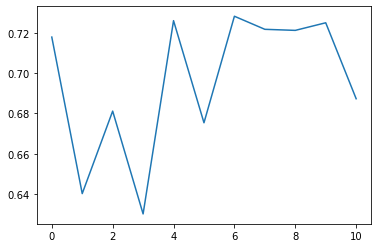

In [35]:
plt.plot(result.history['val_binary_accuracy'])
test_result = model.evaluate([X_test, np.array([counts_aa(xi) for xi in X_test])], y_test)
plt.show()

Let's see how the model works with classical positive-negative classification

In [52]:
labels = np.concatenate(
    (
        np.ones(pos_data.shape[0], dtype=pos_data.dtype),
        np.zeros(neg_data.shape[0], dtype=neg_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, neg_data), axis=0)
counts_features = np.array([counts_aa(xi) for xi in features])
shuffler = np.random.permutation(len(features))
features = features[shuffler]
counts_features = counts_features[shuffler]
labels = labels[shuffler]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=25)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=25)

In [53]:
tf.keras.backend.clear_session()
model = build_model(L)
opt = tf.optimizers.Adam(lr_decayed_fn)
model.compile(
      opt,
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      steps_per_execution = 60 if use_tpu else None,
      metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)])

In [54]:
result = model.fit(
    [X_train, np.array([counts_aa(xi) for xi in X_train])], y_train, 
    validation_data=([X_val, np.array([counts_aa(xi) for xi in X_val])] , y_val),
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=5)],
    epochs=150)

Epoch 1/150
lr = 0.001
484/484 [==============================] - 26s 38ms/step - loss: 0.2788 - auc: 0.9180 - binary_accuracy: 0.8528 - val_loss: 0.2838 - val_auc: 0.9206 - val_binary_accuracy: 0.8422
Epoch 2/150
lr = 0.00099864
484/484 [==============================] - 16s 32ms/step - loss: 0.2587 - auc: 0.9279 - binary_accuracy: 0.8607 - val_loss: 0.2665 - val_auc: 0.9236 - val_binary_accuracy: 0.8516
Epoch 3/150
lr = 0.0009945672
484/484 [==============================] - 16s 33ms/step - loss: 0.2529 - auc: 0.9311 - binary_accuracy: 0.8663 - val_loss: 0.2663 - val_auc: 0.9236 - val_binary_accuracy: 0.8524
Epoch 4/150
lr = 0.0009878038
484/484 [==============================] - 16s 33ms/step - loss: 0.2526 - auc: 0.9315 - binary_accuracy: 0.8651 - val_loss: 0.2679 - val_auc: 0.9255 - val_binary_accuracy: 0.8604
Epoch 5/150
lr = 0.0009783866
484/484 [==============================] - 16s 33ms/step - loss: 0.2512 - auc: 0.9315 - binary_accuracy: 0.8673 - val_loss: 0.2607 - val_auc: 0

11/11 [==============================] - 0s 14ms/step - loss: 0.2467 - auc: 0.9434 - binary_accuracy: 0.8692


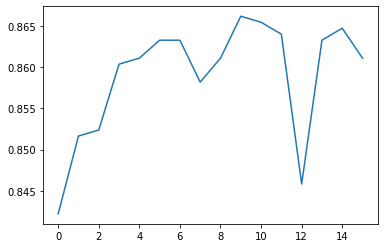

In [55]:
plt.plot(result.history['val_binary_accuracy'])
test_result = model.evaluate([X_test, np.array([counts_aa(xi) for xi in X_test])], y_test)
plt.show()